Ce notebook à été inspiré du code donné dans l'ennoncé : https://www.tensorflow.org/text/tutorials/nmt_with_attention#setup

In [ ]:
!pip install tensorflow_text

In [12]:
import numpy as np
import pandas as pd
import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [7]:
df = pd.read_csv("/content/train.csv")

In [27]:
df.head(5)

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257


In [35]:
inp = df.RawText.tolist()
targ = df.ICD10.tolist()

### Créer un ensemble de données tf.data

In [28]:
BUFFER_SIZE = len(df.RawText.tolist())
BATCH_SIZE = 512

dataset = tf.data.Dataset.from_tensor_slices((df.RawText.tolist(), df.ICD10.tolist())).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)


In [29]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break


tf.Tensor(
[b'Traumatisme voir aussi Traumatisme, vaisseau en question axillaire art\xc3\xa8re'
 b'Isch\xc3\xa9mie thrombolique cardiaque'
 b'Carcinome malpighien infiltrant oropharynx'
 b'Xa) anti-XIa taux de cat\xc3\xa9cholamines dans les urines'
 b'Carcinose grand \xc3\xa9piploon'], shape=(5,), dtype=string)

tf.Tensor([b'S450' b'I259' b'C109' b'R825' b'C786'], shape=(5,), dtype=string)


In [103]:
def tf_lower_and_split_punct(text):
  # Nettoyage des données
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.!?]', '')
  # On enlèeve la ponctuation
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  text = tf.strings.strip(text)
  # Ajout des tokens
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [111]:
# Ajout des tokens aux labels
def tf_lower_lab(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

### Vectorisation de texte
Cette fonction de normalisation sera enveloppé dans une tf.keras.layers.TextVectorization couche qui va gérer l'extraction du vocabulaire et de la conversion du texte d'entrée à des séquences de jetons.

In [107]:
max_vocab_size = 36000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)


In [108]:
input_text_processor.adapt(inp)
# Les mots les plus présent dans le vocabulaire
input_text_processor.get_vocabulary()[:10]


['', '[UNK]', '[START]', '[END]', 'de', 'a', ',', 'aussi', 'voir', 'gauche']

In [112]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_lab,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]


['',
 '[UNK]',
 '[START]',
 '[END]',
 'S062',
 'C798',
 'C859',
 'C349',
 'Z924',
 'I251']

In [114]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)


'[START] traumatisme voir aussi traumatisme , vaisseau en question axillaire artere [END]               '

In [116]:
embedding_dim = 256
units = 1024


In [117]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")


###L'Encodeur
Il prend une liste d'ID de jeton et retourne la séquence et l'état interne

In [118]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # Convertir tokens vers vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))
    return output, state

In [119]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


Input batch, shape (batch): (512,)
Input batch tokens, shape (batch, s): (512, 27)
Encoder output, shape (batch, s, units): (512, 27, 1024)
Encoder state, shape (batch, units): (512, 1024)


L'encodeur renvoie son état interne afin que son état puisse être utilisé pour initialiser le décodeur.

In [120]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [121]:
attention_layer = BahdanauAttention(units)

In [122]:
(example_tokens != 0).shape

TensorShape([512, 27])

In [123]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')


Attention result shape: (batch_size, query_seq_length, units):           (512, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (512, 2, 27)


In [192]:
attention_weights.shape

TensorShape([512, 2, 27])

In [126]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]


### Le décodeur
Il reçoit la sortie de l'encodeur et il génère des prédictions pour le prochain jeton en fonction du vecteur d'attention. 


In [128]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


In [129]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any


In [130]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [131]:
Decoder.call = call

In [132]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)


In [133]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])


In [134]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')


logits shape: (batch_size, t, output_vocab_size) (512, 1, 9252)
state shape: (batch_size, dec_units) (512, 1024)


In [135]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)


Décodage des jeton comme premier mot de la sortie 

In [136]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]


array([['M00'],
       ['W30'],
       ['H722'],
       ['M949'],
       ['Y575']], dtype='<U7')

In [137]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)


In [138]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]


array([['Q332'],
       ['Y648'],
       ['D360'],
       ['Z082'],
       ['I843']], dtype='<U7')

### Entraînement


In [139]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [140]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)


In [141]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [142]:
TrainTranslator._preprocess = _preprocess

In [143]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}


In [144]:
TrainTranslator._train_step = _train_step

In [145]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [146]:
TrainTranslator._loop_step = _loop_step

In [147]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [148]:
np.log(output_text_processor.vocabulary_size())


9.13259502335133

In [149]:
%%time
for n in range(5):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.0889>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.035263>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.870974>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.175236>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2471733>}

CPU times: user 2min, sys: 1.72 s, total: 2min 1s
Wall time: 1min 5s


In [150]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)


In [151]:
TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True


In [152]:
translator.train_step([example_input_batch, example_target_batch])


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.040354>}

In [153]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.5202725>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.4609401>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.334181>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.3542612>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.3747385>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.3289816>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.2777736>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.267628>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.265059>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.2204478>}

CPU times: user 3min 47s, sys: 2.1 s, total: 3min 49s
Wall time: 2min 4s


In [154]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [155]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')


In [156]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
356/356 [==============================] - 3340s 9s/step - batch_loss: 2.5630
Epoch 2/3
356/356 [==============================] - 3361s 9s/step - batch_loss: 1.5137
Epoch 3/3
356/356 [==============================] - 3323s 9s/step - batch_loss: 0.8099


In [157]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))


In [158]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)


In [159]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [160]:
Translator.tokens_to_text = tokens_to_text

In [161]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()


array([b'Q338 K44', b'H602 F332', b'T560 D163', b'H220 D373',
       b'A751 P584'], dtype=object)

In [162]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [163]:
Translator.sample = sample

In [164]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [165]:
Translator.translate = translate_unrolled

In [166]:
test =  pd.read_csv("/content/test.csv")

In [180]:
mytest = test.RawText.tolist()
true_label = test.ICD10.tolist()

In [182]:
%%time

length = 20 
input_text = tf.constant(mytest[:20])

result = translator.translate(
    input_text = input_text)

for i in range(length):
  print("predicted label :",result['text'][i].numpy().decode())
  print("true label :", true_label[i])
  print()


predicted label : M548
true label : R529

predicted label : I772
true label : S352

predicted label : S270
true label : S270

predicted label : B909
true label : B909

predicted label : A071
true label : A071

predicted label : E162
true label : P704

predicted label : S145
true label : P152

predicted label : I800
true label : O873

predicted label : I495
true label : I495

predicted label : C760
true label : C760

predicted label : A448
true label : M543

predicted label : B676
true label : B679

predicted label : N288
true label : N288

predicted label : H212
true label : H212

predicted label : D430
true label : D431

predicted label : P072
true label : F489

predicted label : G409
true label : G403

predicted label : I879
true label : O873

predicted label : O663
true label : O640

predicted label : I891
true label : I891

CPU times: user 506 ms, sys: 15 ms, total: 521 ms
Wall time: 688 ms


In [188]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')


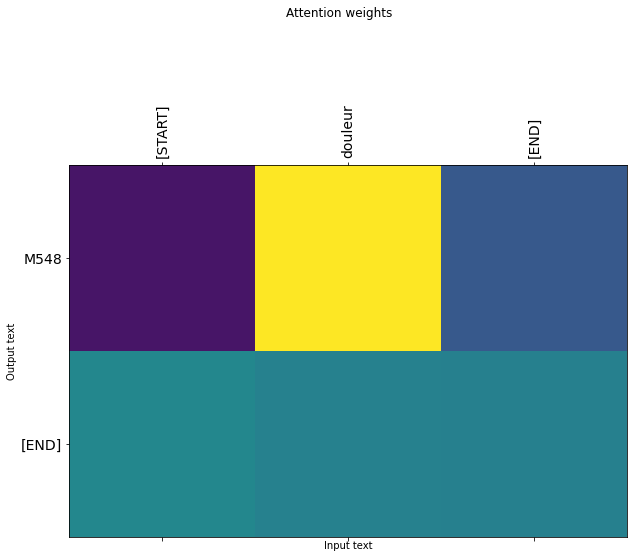

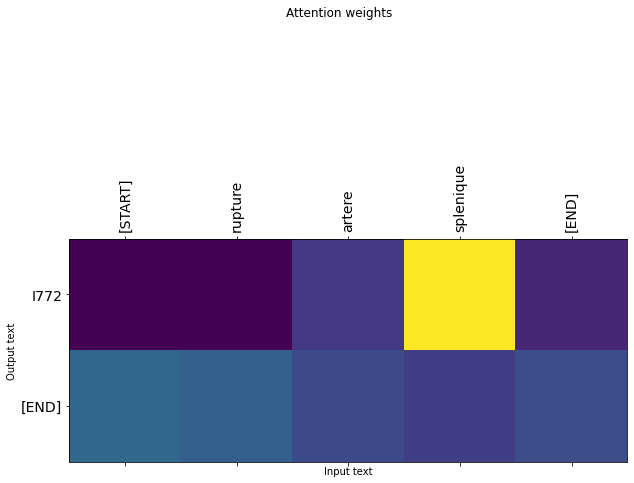

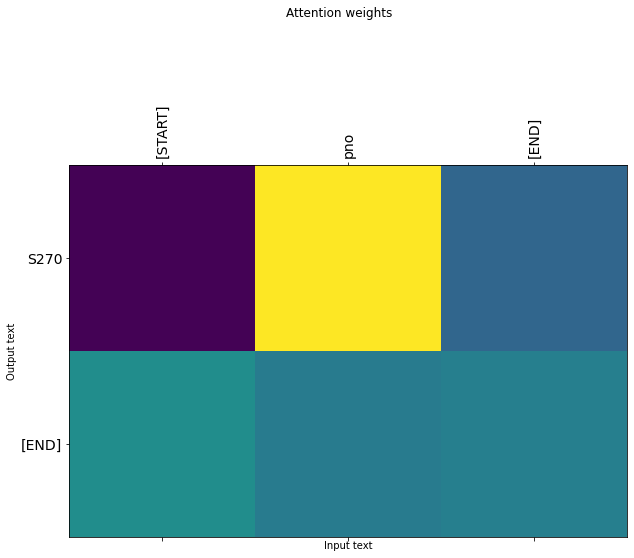

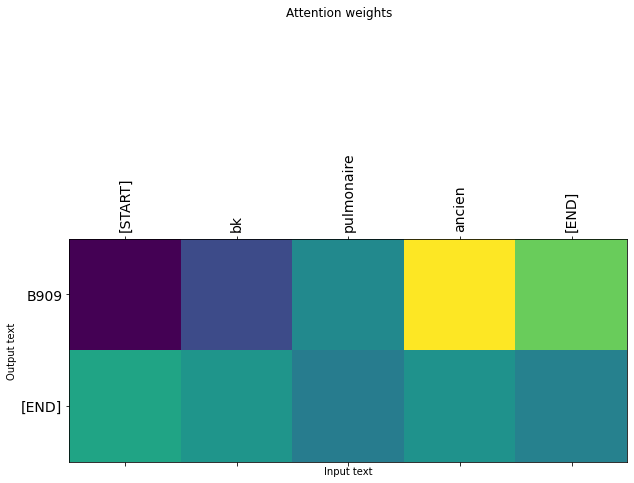

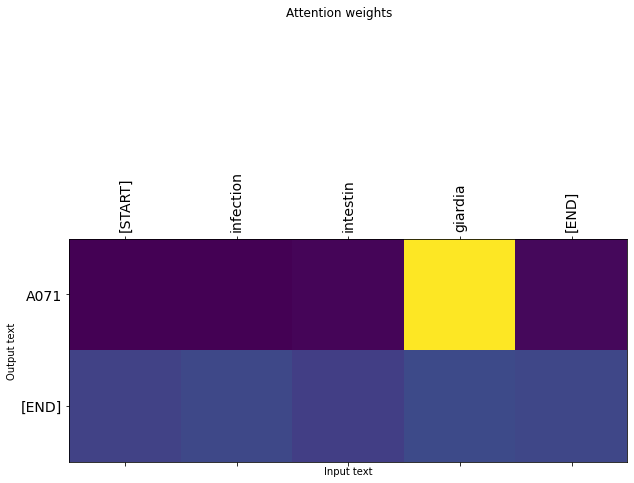

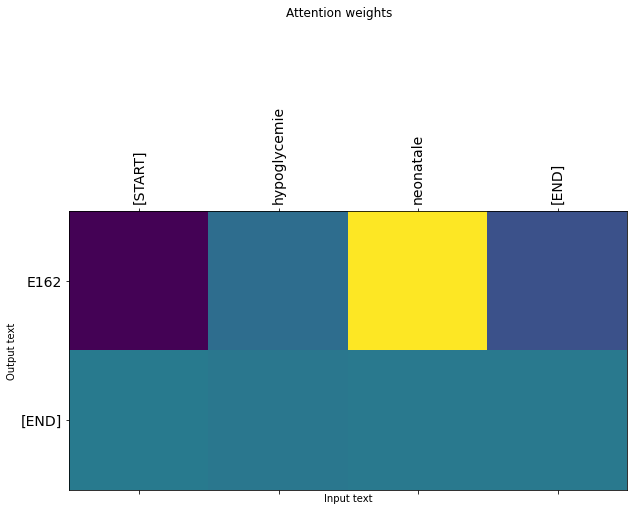

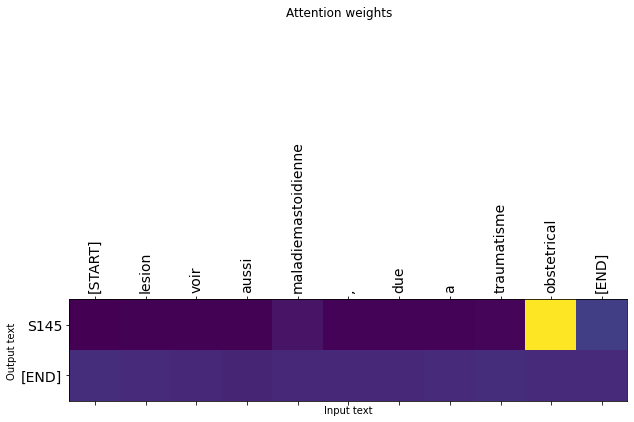

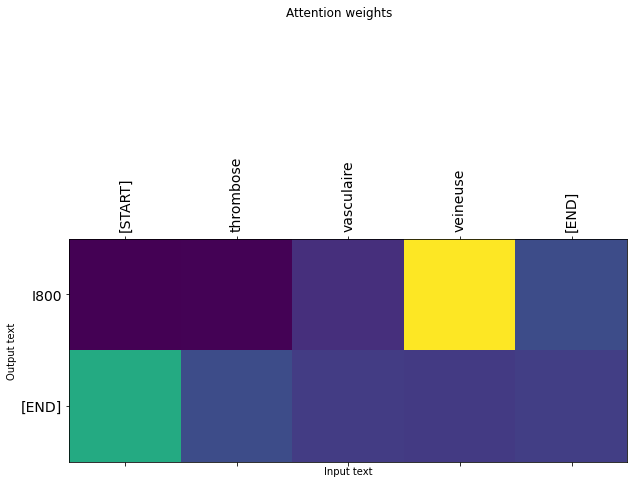

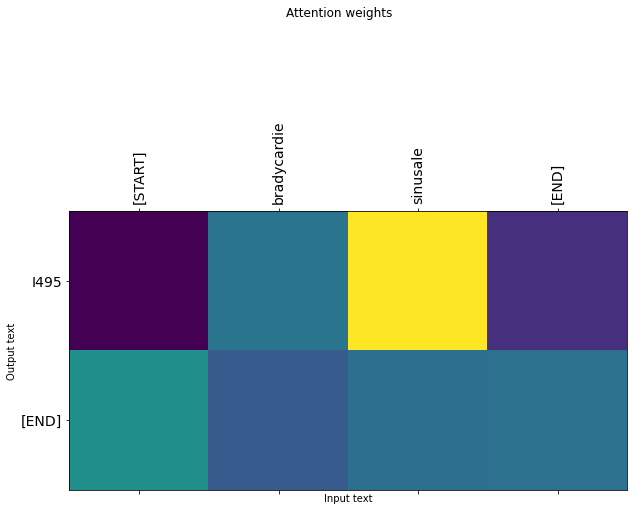

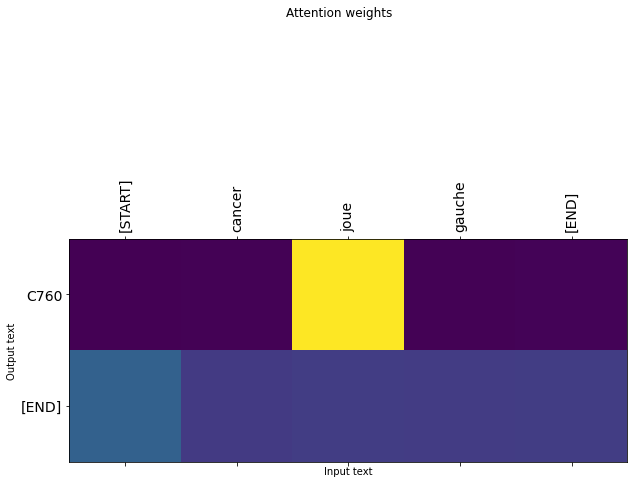

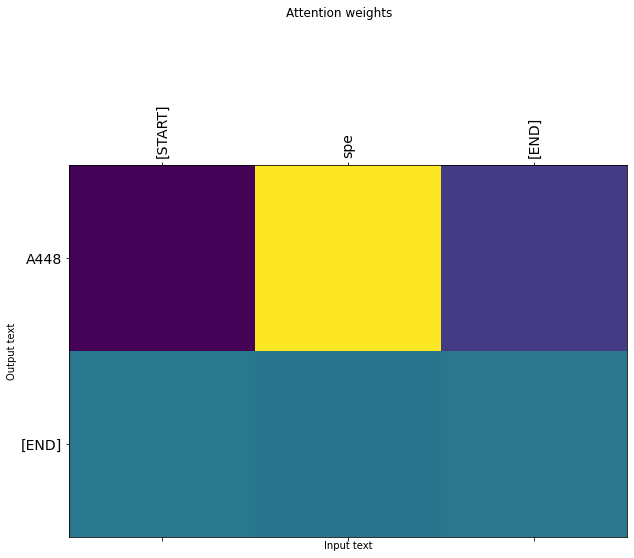

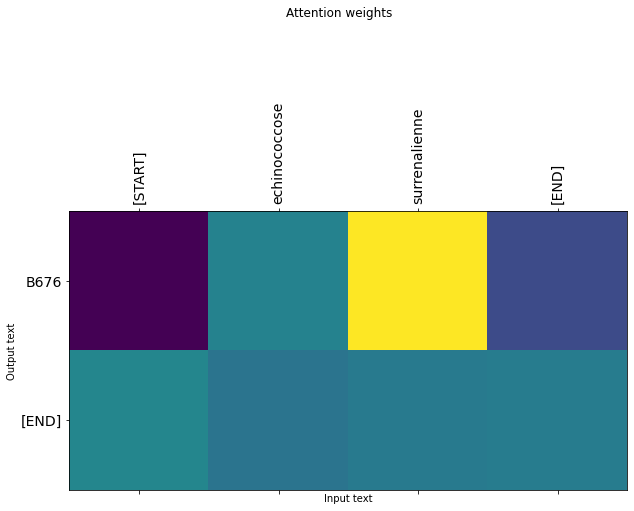

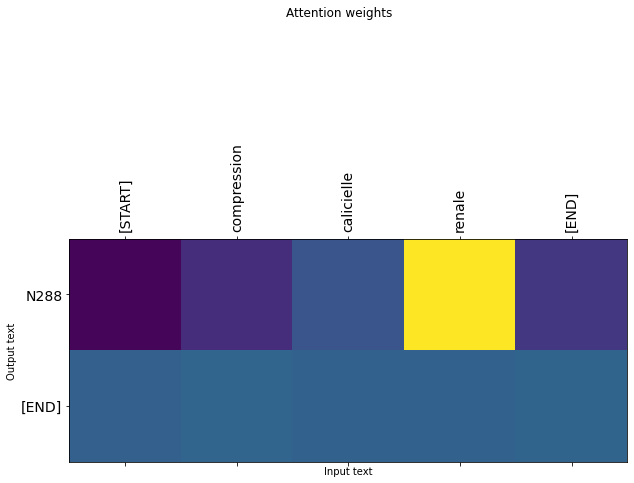

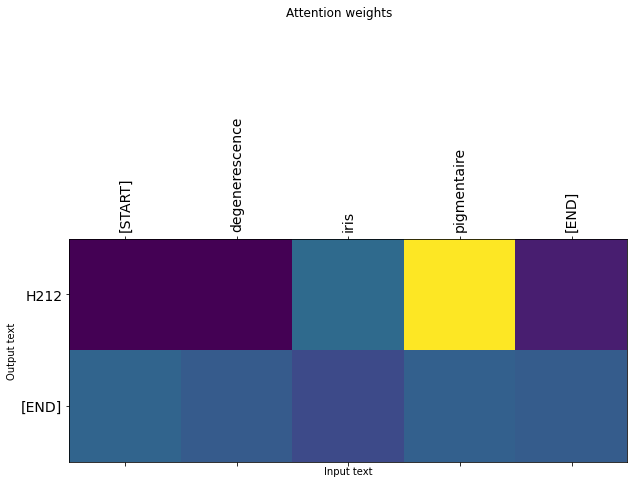

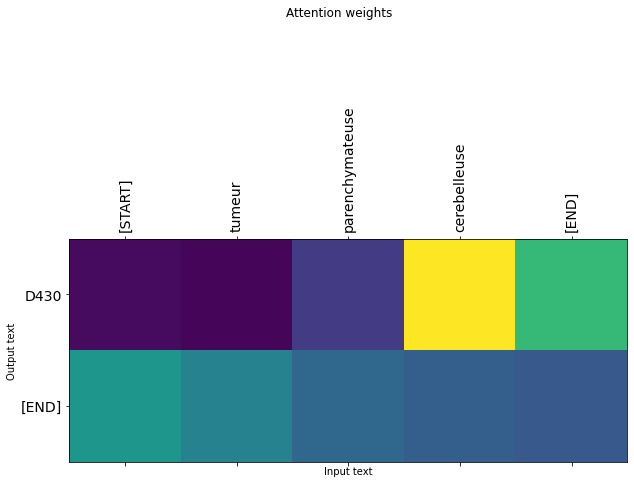

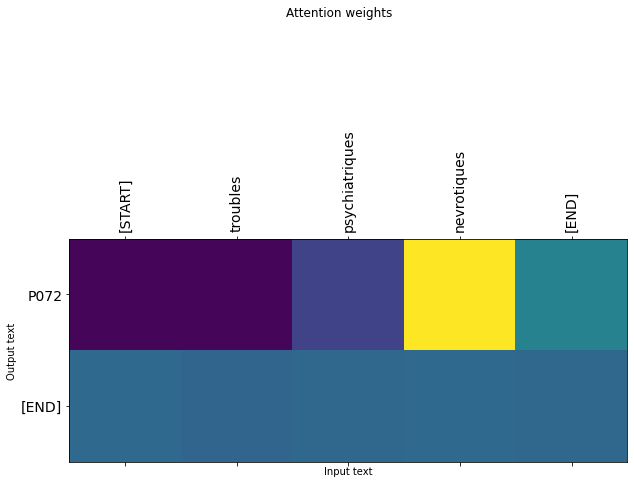

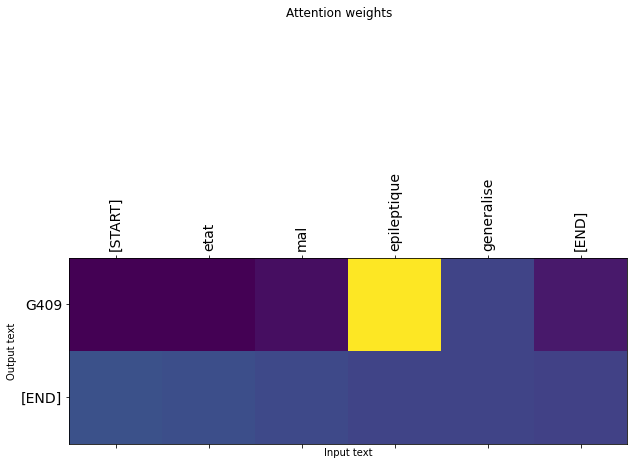

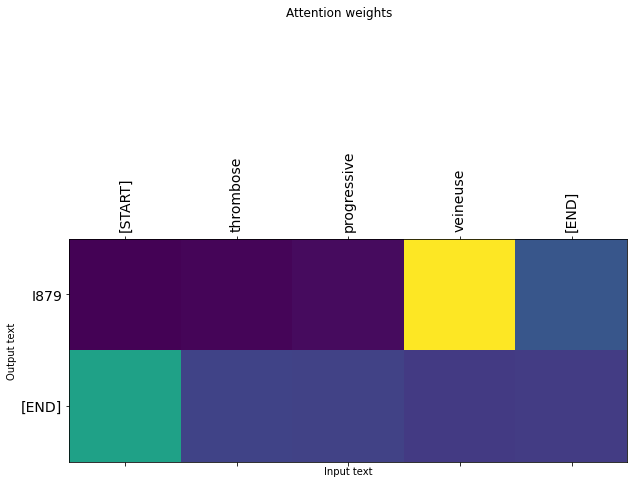

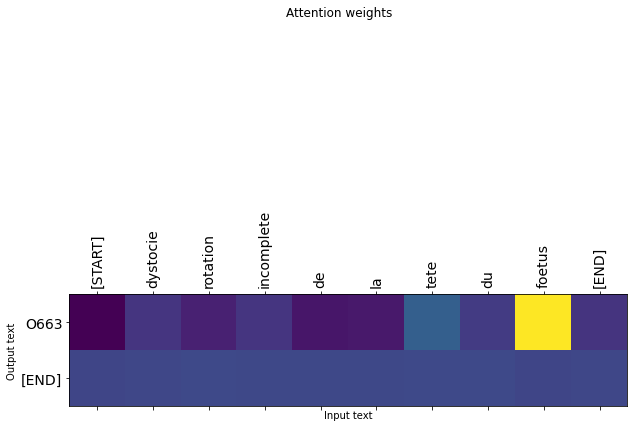

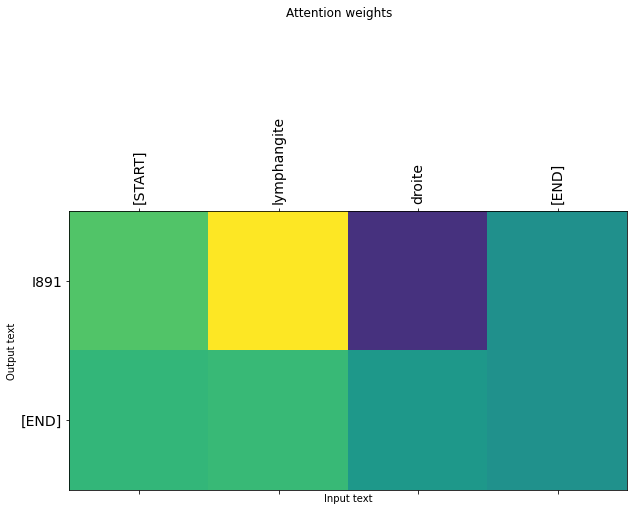

In [193]:
for i in range(20):
  plot_attention(result['attention'][i], input_text[i], result['text'][i])


